# 1. GBDT - Assignment (LightGBDT)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pandas==1.1.3
!pip install -U lightgbm --install-option=--gpu

/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Requirement already up-to-date: lightgbm in /usr/local/lib/python3.6/dist-packages (3.1.0)


In [3]:
import numpy as np
import cupy as cp
import pandas as pd
pd.set_option('display.width', 5)
pd.set_option('display.max_colwidth', 5)

import lightgbm as lgb
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from gc import collect

data_path = '/content/drive/MyDrive/6_Donors_choose_NB/preprocessed_data.csv'
w2v_path = '/content/drive/MyDrive/6_Donors_choose_NB/glove_vectors'
train_path = '/content/drive/MyDrive/6_Donors_choose_NB/train_data.csv'

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## **1.1 Read Dataset:**

In [4]:
data = pd.read_csv(data_path, nrows=100000)

data['project_title'] = pd.read_csv(train_path, nrows=100000)['project_title']

print(list(data.columns))

['school_state', 'teacher_prefix', 'project_grade_category', 'teacher_number_of_previously_posted_projects', 'project_is_approved', 'clean_categories', 'clean_subcategories', 'essay', 'price', 'project_title']


### **1.1.1 Project-Title Cleaning**

In [5]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [6]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [7]:
print("printing some random reviews")
print(9, data['project_title'].values[9])
print(34, data['project_title'].values[34])
print(147, data['project_title'].values[147])

printing some random reviews
9 Just For the Love of Reading--\r\nPure Pleasure
34 \"Have A Ball!!!\"
147 Who needs a Chromebook?\r\nWE DO!!


In [8]:
# Combining all the above stundents 
from tqdm import tqdm

def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [9]:
data['project_title'] = preprocess_text(data['project_title'].values)

100%|██████████| 100000/100000 [00:02<00:00, 45307.41it/s]


### **1.1.2 Data-Splitting**

In [10]:
xtrain, xtest, ytrain, ytest = train_test_split(data, data['project_is_approved'], 
                                                test_size=0.40,
                                                stratify=data['project_is_approved'])

print("\nData-Shape : ", xtrain.shape, xtest.shape, ytrain.shape, ytest.shape, "\n")

del data
collect()

categories = ['school_state', 'teacher_prefix', 'project_grade_category', 'clean_categories', 'clean_subcategories']
numeric = ['teacher_number_of_previously_posted_projects', 'price']
text = ['essay']


Data-Shape :  (60000, 10) (40000, 10) (60000,) (40000,) 



## **1.2 Feature-Preprocessing**

### **1.2.1 Responsive-Coding**

In [11]:
def getResponseCoding(df, cat):
    df= pd.crosstab(index=df[str(cat)], columns=df['project_is_approved']).reset_index()
    df['total'] = df.sum(axis=1)
    df['neg_prob'] = df[0]/df['total']
    df['pos_prob'] = df[1]/df['total']
    return df

def getTestResponseCoding(df, cat, encode_df):
    negative_prob = []
    positive_prob = []
    for i in encode_df[str(cat)]:
        try:
            negative_prob.append(df[df[str(cat)] == str(i)].neg_prob.values[0])
            positive_prob.append(df[df[str(cat)] == str(i)].pos_prob.values[0])
        except:
            negative_prob.append(0.5)
            positive_prob.append(0.5)
    return np.asarray(negative_prob), np.asarray(positive_prob)

In [12]:
for cat in categories:
    df= getResponseCoding(xtrain, cat)
    xtrain[str(cat) + '_0_prob'], xtrain[str(cat) + '_1_prob'] = getTestResponseCoding(df, cat, xtrain)
    xtest[str(cat) + '_0_prob'], xtest[str(cat) + '_1_prob'] = getTestResponseCoding(df, cat, xtest)

    xtrain=xtrain.drop(columns=[cat])
    xtest=xtest.drop(columns=[cat])

    collect()

### **1.2.2 TFIDF Vectorizer**

In [13]:
def getFitTFIDF_Vectorizer(preprocessed_data):
    vectorizer = TfidfVectorizer(ngram_range=(2,2), max_features=5000, min_df=10)
    vectorizer.fit(preprocessed_data)
    return vectorizer

def getTFIDFVectorizeTxtData(preprocessed_data, vectorizer):
    text_tfidf = vectorizer.transform(preprocessed_data)
    print("Shape of matrix after tfidf encodig ",text_tfidf.shape)
    return text_tfidf

### **1.2.3 TFIDF weighted W2V**

In [35]:
import pickle 

with open(w2v_path, 'rb') as f:    
  model = pickle.load(f)    
  glove_words =  set(model.keys())

In [36]:
def TFIDF_W2V(preprocessed_data):
    tfidf_model = TfidfVectorizer()
    tfidf_model.fit(preprocessed_data)
    return tfidf_model

def getTFIDF_W2V(preprocessed_data, tfidf_model):
    
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    tfidf_words = set(tfidf_model.get_feature_names())
    
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(preprocessed_data): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)

    print(len(tfidf_w2v_vectors))
    print(len(tfidf_w2v_vectors[0]))
    
    return np.asarray(tfidf_w2v_vectors)

### **1.2.4 Standardize Numerical Value**

In [16]:
for num in numeric:
    scaler = StandardScaler()
    
    scaler = scaler.fit(xtrain[num].values.reshape(-1,1))

    xtrain["std_" +str(num)] = scaler.transform(xtrain[num].values.reshape(-1,1))
    xtest["std_" +str(num)]= scaler.transform(xtest[num].values.reshape(-1,1))

    xtrain=xtrain.drop(columns=[num])
    xtest=xtest.drop(columns=[num])

    collect()

xtrain = xtrain.drop(columns=['project_is_approved'])
xtest = xtest.drop(columns=['project_is_approved'])

In [17]:
xtest, xcv, ytest, ycv = train_test_split(xtest, ytest, test_size=0.50,
                                          stratify=ytest)

X_train_essay = xtrain['essay']
X_test_essay = xtest['essay']
X_cv_essay = xcv['essay']
X_train_title = xtrain['project_title']
X_test_title = xtest['project_title']
X_cv_title = xcv['project_title']

xtrain = xtrain.drop(columns=['essay', 'project_title'])
xtest = xtest.drop(columns=['essay', 'project_title'])
xcv = xcv.drop(columns=['essay', 'project_title'])

## **1.3. Sentiment Intensity Analyser**

In [18]:
def sentiment_anayser(essay):

    sid = SentimentIntensityAnalyzer()
    negative = []
    positive = []
    neutral = []
    compound = []

    for sentence in essay:
        ss = sid.polarity_scores(sentence)
        sentmnt = list(ss.values())
        neg = sentmnt[0]
        neu = sentmnt[1]
        pos = sentmnt[2]
        cmpd = sentmnt[3]

        negative.append(neg)
        neutral.append(neu)
        positive.append(pos)
        compound.append(cmpd)

    return np.column_stack((np.array(negative), np.array(neutral),
                            np.array(positive), np.array(compound)))

## **1.4 Hyper-Parameter Tuning**

In [ ]:
sets = ['tfidf', 'w2v']
scorer = dict()


for set_ in sets:

    if set_ == 'tfidf':
        vectorizer = getFitTFIDF_Vectorizer(X_train_title)
        temp_1 = getTFIDFVectorizeTxtData(X_train_title, vectorizer).toarray()
        temp_2 = getTFIDFVectorizeTxtData(X_cv_title, vectorizer).toarray()

        vectorizer = getFitTFIDF_Vectorizer(X_train_essay)

        temp_1 = np.column_stack(
            (temp_1, getTFIDFVectorizeTxtData(X_train_essay, vectorizer).toarray()))
        
        temp_2 = np.column_stack(
            (temp_2, getTFIDFVectorizeTxtData(X_cv_essay, vectorizer).toarray()))


        temp_1 = np.column_stack((temp_1, sentiment_anayser(X_train_essay),
                                  xtrain.values))
        print("Final_Train_Matrix : ", temp_1.shape)

        temp_2 = np.column_stack((temp_2, sentiment_anayser(X_cv_essay),
                                  xcv.values))
        print("Final_CV_Matrix : ", temp_2.shape)

    elif set_ == 'w2v':
        vectorizer1 = TFIDF_W2V(X_train_title)
        temp_1 = getTFIDF_W2V(X_train_title, vectorizer1)

        vectorizer2 = TFIDF_W2V(X_train_essay)
        temp_2 = getTFIDF_W2V(X_train_essay, vectorizer2)

        temp_1 = np.column_stack((temp_1, temp_2,
                                  sentiment_anayser(X_train_essay)))
        temp_1 = np.column_stack((temp_1, xtrain.values))
        print("Final_Train_Matrix : ", temp_1.shape)

        essay_ = getTFIDF_W2V(X_cv_essay, vectorizer2)
        temp_2 = getTFIDF_W2V(X_cv_title, vectorizer1)
        temp_2 = np.column_stack((temp_2, essay_, sentiment_anayser(X_cv_essay)))
        temp_2 = np.column_stack((temp_2, xcv.values))
        print("Final_CV_Matrix : ", temp_2.shape)

    parameters={"early_stopping_rounds": 10,
                "eval_metric" : 'auc', 
                "eval_set" : [(temp_2,ycv)],
                'eval_names': ['valid'],
                'verbose': False}

    parameter_tuning ={
             'max_depth':  [5, 10, 50, 100, 500],
             'min_child_samples': [5, 10, 100, 500]}

    classifier = lgb.LGBMClassifier(device="gpu", random_state=300, silent=True, metric='auc', n_jobs=-1)

    find_parameters = RandomizedSearchCV(
        estimator=classifier, param_distributions=parameter_tuning, 
        n_iter=100,
        scoring='roc_auc',
        cv=5,
        refit=True,
        random_state=300,
        verbose=False,
        return_train_score=True)
    
    scorer[set_] = find_parameters
    
    find_parameters.fit(temp_1, ytrain, **parameters)
    print("\n#"*50, set_, " : \n#"*50)
    print('Best score : {} with parameters: {} '.format(find_parameters.best_score_, find_parameters.best_params_), "\n\n")

    del temp_1
    del temp_2
    collect()

In [20]:
scorer['tfidf'].cv_results_

{'mean_fit_time': array([29.37143335, 31.39018006, 27.21542997,  8.12709513, 41.43432875,
        40.39781775, 31.45694046,  9.65661631, 44.139961  , 42.00484724,
        36.59567299, 10.57228518, 43.09559617, 41.77202759, 36.69225626,
        10.745749  , 44.02288251, 41.73093138, 36.49613132, 10.53993392]),
 'mean_score_time': array([0.23542137, 0.24028544, 0.23931074, 0.24317222, 0.25397229,
        0.25247755, 0.25618491, 0.2577342 , 0.25270042, 0.25672455,
        0.26740789, 0.24944429, 0.2450706 , 0.24963655, 0.26820102,
        0.2621449 , 0.25417643, 0.25424833, 0.2626502 , 0.25620427]),
 'mean_test_score': array([0.68654277, 0.68751047, 0.69218654, 0.68715998, 0.68887255,
        0.6892439 , 0.69749857, 0.69014198, 0.69072152, 0.69357233,
        0.70046676, 0.6918717 , 0.69072666, 0.69357233, 0.70046936,
        0.69187132, 0.69072417, 0.69357232, 0.70046815, 0.69187171]),
 'mean_train_score': array([0.81392229, 0.80250993, 0.76146983, 0.73273681, 0.87682745,
        0.86966

In [21]:
scorer['w2v'].cv_results_

{'mean_fit_time': array([12.45913095, 11.45425334, 11.63125157, 11.0970192 , 14.04449425,
        13.53438344, 13.66393027, 12.85403032, 14.68655062, 14.40972233,
        13.12716689, 13.6660224 , 15.25874944, 15.00568595, 13.42132525,
        13.76135445, 14.84979615, 14.34800215, 12.93694773, 13.40485387]),
 'mean_score_time': array([0.07960014, 0.06964822, 0.07919188, 0.08095231, 0.07683854,
        0.06996531, 0.07865176, 0.08247004, 0.07735615, 0.07423143,
        0.07247477, 0.08878732, 0.078967  , 0.07787123, 0.07361207,
        0.0891757 , 0.07813673, 0.07357512, 0.0693224 , 0.09025116]),
 'mean_test_score': array([0.71459794, 0.71347811, 0.71464447, 0.71745185, 0.71322064,
        0.71396769, 0.71479425, 0.71657016, 0.71295019, 0.71380615,
        0.71497047, 0.7171578 , 0.71296159, 0.71381891, 0.71495712,
        0.71715777, 0.71294678, 0.71376658, 0.71495382, 0.71715677]),
 'mean_train_score': array([0.87269034, 0.85131101, 0.85777606, 0.83358297, 0.87824685,
        0.86727

In [22]:
print("TFIDF BEST PARAMS : " , scorer['tfidf'].best_params_)
print("TFIDF BEST AUC-Score : " , scorer['tfidf'].best_score_, "\n\n")

print("TFIDF_Wheighted_W2V - BEST PARAMS : " , scorer['w2v'].best_params_)
print("TFIDF_Wheighted_W2V - BEST AUC-Score : " , scorer['w2v'].best_score_)

TFIDF BEST PARAMS :  {'min_child_samples': 100, 'max_depth': 100}
TFIDF BEST AUC-Score :  0.7004693567560001 


TFIDF_Wheighted_W2V - BEST PARAMS :  {'min_child_samples': 500, 'max_depth': 5}
TFIDF_Wheighted_W2V - BEST AUC-Score :  0.717451848857623


```
TFIDF BEST PARAMS :  {'min_child_samples': 100, 'max_depth': 100}

TFIDF BEST AUC-Score :  0.7004693567560001 


TFIDF_Wheighted_W2V - BEST PARAMS :  {'min_child_samples': 500, 'max_depth': 5}

TFIDF_Wheighted_W2V - BEST AUC-Score :  0.717451848857623

```

## **1.5 CV-Results Representation**

In [27]:
mean_test_score = scorer['w2v'].cv_results_['mean_test_score']
mean_train_score = scorer['w2v'].cv_results_['mean_train_score']
params = scorer['w2v'].cv_results_['params']

min_child_samples = []
max_depth = []
for parameter in params:
    min_child_samples.append(parameter['min_child_samples'])
    max_depth.append(parameter['max_depth'])

df = pd.DataFrame()
df['min_child_samples'] = pd.Series(min_child_samples)
df['mean_test_score'] = pd.Series(mean_test_score)
df['mean_train_score'] = pd.Series(mean_train_score)
df['max_depth'] = pd.Series(max_depth)

df.head()

,min_child_samples,mean_test_score,mean_train_score,max_depth
0,5,0...,0...,5
1,10,0...,0...,5
2,100,0...,0...,5
3,500,0...,0...,5
4,5,0...,0...,10


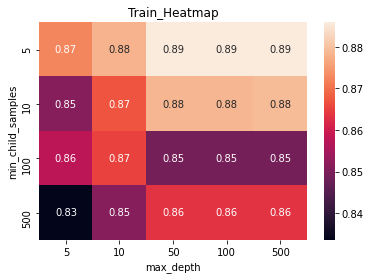

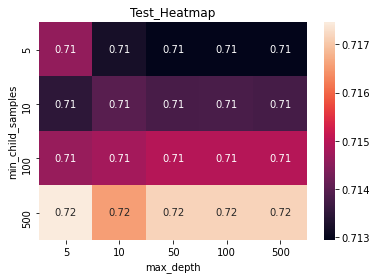

In [28]:
train_heatmap = df.pivot(index='min_child_samples', columns='max_depth',
                         values='mean_train_score')
test_heatmap = df.pivot(index='min_child_samples', columns='max_depth',
                        values='mean_test_score')

sns.heatmap(train_heatmap, annot=True)
plt.title("Train_Heatmap")
plt.show()

sns.heatmap(test_heatmap, annot=True)
plt.title("Test_Heatmap")
plt.show()

## **1.6 Model-Training**

In [39]:
vectorizer1 = TFIDF_W2V(X_train_title)
temp_1 = getTFIDF_W2V(X_train_title, vectorizer1)

vectorizer2 = TFIDF_W2V(X_train_essay)
temp_2 = getTFIDF_W2V(X_train_essay, vectorizer2)

temp_1 = np.column_stack((temp_1, temp_2,
                            sentiment_anayser(X_train_essay)))
temp_1 = np.column_stack((temp_1, xtrain.values))

print("Final_Train_Matrix : ", temp_1.shape)

essay_ = getTFIDF_W2V(X_test_essay, vectorizer2)
temp_2 = getTFIDF_W2V(X_test_title, vectorizer1)
temp_2 = np.column_stack((temp_2, essay_, sentiment_anayser(X_test_essay)))
temp_2 = np.column_stack((temp_2, xtest.values))
print("Final_Test_Matrix : ", temp_2.shape)

Final_Train_Matrix :  (60000, 616)
Final_Test_Matrix :  (20000, 616)


In [40]:
clf = lgb.LGBMClassifier(min_child_samples = 500, max_depth = 5, device="gpu", random_state=300, silent=True, metric='auc', n_jobs=-1)
clf.fit(temp_1, ytrain)
Y_pred = clf.predict(temp_2)

## **1.7 Confusion - Matrix**

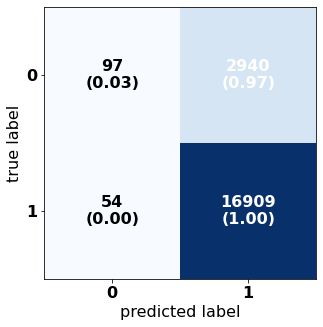

In [41]:
from mlxtend.plotting import plot_confusion_matrix

font = {
'family' : 'DejaVu Sans',
'weight' : 'bold',
'size' : '16'
}
plt.rc('font', **font)
mat = confusion_matrix(ytest, Y_pred)
plot_confusion_matrix(conf_mat=mat, figsize=(5,5), show_normed=True);

## **1.8 AUC Score**

In [44]:
from sklearn.metrics import auc, roc_curve

print("train_roc_auc_score : " , roc_auc_score(ytrain, clf.predict(temp_1)),
      '\n')
print("test_roc_auc_score : ", roc_auc_score(ytest, Y_pred), 
      '\n')

probs = clf.predict_proba(temp_1)
probs = probs[:, 1]
train_fpr, train_tpr, train_thresholds = roc_curve(ytrain, probs)
probs = clf.predict_proba(temp_2)
probs = probs[:, 1]
test_fpr, test_tpr, test_thresholds = roc_curve(ytest, probs)
print("train_auc_score : " , auc(train_fpr, train_tpr), '\n')
print("test_auc_score : ", auc(test_fpr, test_tpr), '\n')


train_roc_auc_score :  0.5288673359535072 

test_roc_auc_score :  0.5143780073662038 

train_auc_score :  0.8264402979328005 

test_auc_score :  0.7057330476443617 



train_auc_score :  0.8264402979328005 


test_auc_score :  0.7057330476443617 




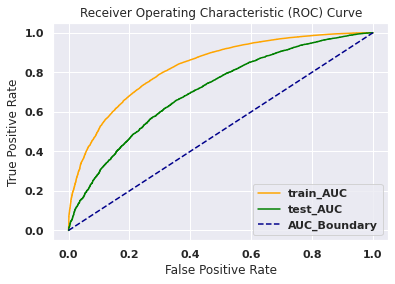

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
sns.set(style='darkgrid')

print("train_auc_score : " , auc(train_fpr, train_tpr), "\n\n")
print("test_auc_score : ", auc(test_fpr, test_tpr), "\n\n")


plt.plot(train_fpr, train_tpr, color='orange', label='_train_ROC')
plt.plot(test_fpr, test_tpr, color='green', label='_test_ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(['train_AUC', 'test_AUC', 'AUC_Boundary'])
plt.show();

# **RESULT**

In [46]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyper_Parameter", "Train_AUC", 
                 "Test_AUC"]

x.add_row(["TFIDF-W2V",'LightGBDT', 'max_depth : 5, min_child_samples :500',
           0.89, '0.71(CV)'])

x.add_row(["TFIDF", 'LightGBDT', 'max_depth : 100, min_child_samples : 100',
           0.82, '0.70(CV)'])

x.add_row(["TFIDF-W2V", 'LightGBDT', 'max_depth : 5, min_child_samples : 500',
           0.82, 0.70])

print(x)

+------------+-----------+------------------------------------------+-----------+----------+
| Vectorizer |   Model   |             Hyper_Parameter              | Train_AUC | Test_AUC |
+------------+-----------+------------------------------------------+-----------+----------+
| TFIDF-W2V  | LightGBDT |  max_depth : 5, min_child_samples :500   |    0.89   | 0.71(CV) |
|   TFIDF    | LightGBDT | max_depth : 100, min_child_samples : 100 |    0.82   | 0.70(CV) |
| TFIDF-W2V  | LightGBDT |  max_depth : 5, min_child_samples : 500  |    0.82   |   0.7    |
+------------+-----------+------------------------------------------+-----------+----------+
